In [1]:
!pip install pandas_market_calendars
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!pip install pmdarima
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 8.9 MB/s eta 0:00:00
E: Package 'libfluidsynth1' has no installation candidate
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00


In [2]:
!pip install ucimlrepo  # instalamos el paquete específico llamado ucimlrepo para acceder al dataset elegido

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import plotly.graph_objs as go
from tensorflow.keras.optimizers import Adam

In [4]:
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de datos

In [5]:
#función diseñada para facilitar la descarga de datasets de la colección UCI Machine Learning Repository

from ucimlrepo import fetch_ucirepo
import pandas as pd

#Traigo el  dataset
air_quality = fetch_ucirepo(id=360)

#data (as pandas dataframes)
Xair = air_quality.data.features
yair = air_quality.data.targets

# variable information
print(air_quality.variables)

             name     role         type demographic  \
0            Date  Feature         Date        None   
1            Time  Feature  Categorical        None   
2          CO(GT)  Feature      Integer        None   
3     PT08.S1(CO)  Feature  Categorical        None   
4        NMHC(GT)  Feature      Integer        None   
5        C6H6(GT)  Feature   Continuous        None   
6   PT08.S2(NMHC)  Feature  Categorical        None   
7         NOx(GT)  Feature      Integer        None   
8    PT08.S3(NOx)  Feature  Categorical        None   
9         NO2(GT)  Feature      Integer        None   
10   PT08.S4(NO2)  Feature  Categorical        None   
11    PT08.S5(O3)  Feature  Categorical        None   
12              T  Feature   Continuous        None   
13             RH  Feature   Continuous        None   
14             AH  Feature   Continuous        None   

                                          description       units  \
0                                                N

In [6]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que vamos a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

# Cambiar el nombre de la variable C6H6(GT)
df.rename(columns={'C6H6(GT)': 'C6H6'}, inplace=True)

# Mostrar el DataFrame resultante
print(df.head())

        Date      Time  C6H6     T    RH
0  3/10/2004  18:00:00  11.9  13.6  48.9
1  3/10/2004  19:00:00   9.4  13.3  47.7
2  3/10/2004  20:00:00   9.0  11.9  54.0
3  3/10/2004  21:00:00   9.2  11.0  60.0
4  3/10/2004  22:00:00   6.5  11.2  59.6


In [7]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' pusimos dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [8]:
# Establecer la columna datetime como índice
df.set_index('Datetime', inplace=True)

In [9]:
# Eliminación de las columnas Date y Time
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [10]:
# Verificación numero de filas de la serie
num_filas = len(df)
print(num_filas)

9357


In [11]:
## Analisis de datos faltantes
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna C6H6: 0
	Columna T: 0
	Columna RH: 0


In [12]:
## Analisis de periocidad
df_time_diffs = df.index.to_series().diff().dt.total_seconds() #total_seconds es una función de pandas que retorna la duración total de cada elemento expresada en segundos.
print(df_time_diffs.value_counts())

Datetime
3600.0    9356
Name: count, dtype: int64


*Variable T*

In [13]:
# Crear una traza
trace1 = go.Scatter(x=df.index, y=df['T'], mode='lines', name='T', line=dict(color='darkblue') )

# Crear la figura y añadir las traza
fig = go.Figure(data=[trace1])

# Actualizar el layout
fig.update_layout(
    title='Series Temporales de T',
    xaxis_title='Datetime',
    yaxis_title='Valores',
    legend_title='Series',
    plot_bgcolor='white',  # Fondo del área de trazado blanco
    paper_bgcolor='white'  # Fondo del papel blanco
)

# Actualizar el diseño de los ejes
fig.update_xaxes(
    tickmode='linear',
    tick0=df.index[0],
    dtick='M1',  # Ajuste para mostrar etiquetas mensuales, puedes cambiarlo según sea necesario
    tickformat='%d.%m.%Y',
    gridcolor='lightgrey'  # Color de las líneas de la cuadrícula
)

fig.update_yaxes(
    gridcolor='lightgrey'  # Color de las líneas de la cuadrícula
)

# Mostrar el gráfico una vez
fig.show()


In [14]:
## Se corrigen los datos, para sacar los -200
df['T'] = df['T'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['T'].fillna(method='ffill', inplace=True)

In [15]:
trace1 = go.Scatter(x=df.index, y=df['T'], mode='lines', name='T', line=dict(color='darkblue'))
fig = go.Figure(data=[trace1])

fig.update_layout(
    title='Serie Temporal de T',
    xaxis_title='Datetime',
    yaxis_title='Valores',
    legend_title='Series',
    plot_bgcolor='white',  # Fondo del área de trazado blanco
    paper_bgcolor='white'  # Fondo del papel blanco
)

fig.update_xaxes(
    tickmode='linear',
    tick0=df.index[0],
    dtick='M1',
    tickformat='%d.%m.%Y',
    gridcolor='lightgrey'
)

fig.update_yaxes(
    gridcolor='lightgrey'  #
)

fig.show()

#Modelo Univariado Unistep

**Preprocesamiento de Datos**

In [16]:
df_T = df['T']
print(df_T)

Datetime
2004-03-10 18:00:00    13.6
2004-03-10 19:00:00    13.3
2004-03-10 20:00:00    11.9
2004-03-10 21:00:00    11.0
2004-03-10 22:00:00    11.2
                       ... 
2005-04-04 10:00:00    21.9
2005-04-04 11:00:00    24.3
2005-04-04 12:00:00    26.9
2005-04-04 13:00:00    28.3
2005-04-04 14:00:00    28.5
Name: T, Length: 9357, dtype: float64


In [17]:
#Se separan los datos en entrenamiento (80%), validacion (10%) y test (10%)
def train_val_test_split(df_T, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = df_T.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = df_T[0:Ntrain]
    val = df_T[Ntrain:Ntrain+Nval]
    test = df_T[Ntrain+Nval:]

    return train, val, test

In [18]:
#Verificar tamaños de cada set de entrenamiento, validación y test
tr, vl, ts = train_val_test_split(df_T)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (7485,)
Tamaño set de validación: (935,)
Tamaño set de prueba: (937,)


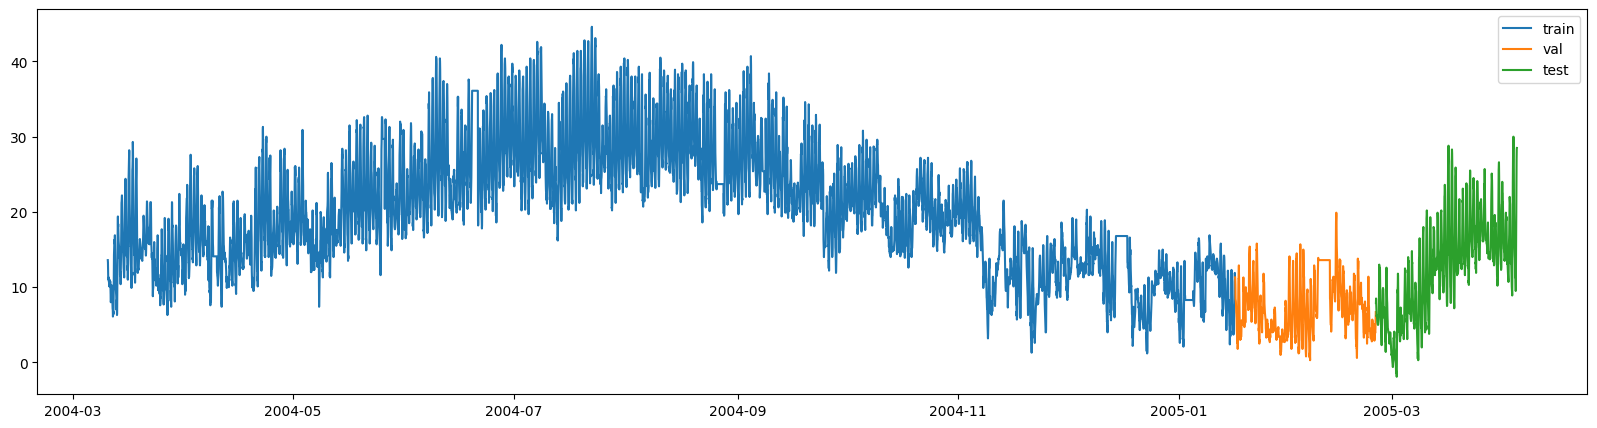

In [19]:
#Grafico de la repartición
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tr,label="train")
ax.plot(vl,label="val")
ax.plot(ts,label="test")
plt.legend();

**Creación del dataset supervisado**

In [20]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos (utilizando ventanas deslizantes de longitud input_length)
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [21]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 48 # empiezo con por la alta estacionalidad diaria que tiene la serie, luego pruebo con 48 para ver si captura algún patrón mayor a un dia
OUTPUT_LENGTH = 1 #prediccion de una hora

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [22]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (7436, 48, 1), y_tr: (7436, 1, 1)
Set de validación - x_vl: (886, 48, 1), y_vl: (886, 1, 1)
Set de prueba - x_ts: (888, 48, 1), y_ts: (888, 1, 1)


**Escalonamiento de los datos**

In [23]:
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [24]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [25]:
data_s, scaler = escalar_dataset(data_in)

In [26]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [27]:
#Verifición
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento:  1.2/0.3/-1.9
Min x_tr/x_vl/x_ts con escalamiento:  -1.0/-1.0414746543778801/-1.1428571428571428
Min y_tr/y_vl/y_ts sin escalamiento:  1.2/0.3/-1.9
Min y_tr/y_vl/y_ts con escalamiento:  -1.0/-1.0414746543778801/-1.1428571428571428
Max x_tr/x_vl/x_ts sin escalamiento:  44.6/19.9/30.0
Max x_tr/x_vl/x_ts con escalamiento:  1.0000000000000002/-0.13824884792626735/0.3271889400921659
Max y_tr/y_vl/y_ts sin escalamiento:  44.6/19.9/30.0
Max y_tr/y_vl/y_ts con escalamiento:  1.0000000000000002/-0.13824884792626735/0.3271889400921659


**Creación y entrenamiento de la red LSTM**

In [28]:
tf.random.set_seed(1234) #para garantizar la reproducibidad del entrenamiento

In [29]:
tf.config.experimental.enable_op_determinism() #realizaremos el entrenamiento usando la GPU proporcionada por Google Colab

In [30]:
#hiperparámetro del modelo a afinar
N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.


In [31]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) #tamaño de cada dato de entrada del modelo 24/48 horas y 1 feature

In [32]:
modelo = Sequential() #modelo vacío a la cual se le adicionaran de manera secuencial los elementos
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE)) #entradas
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) #salidas Dense: es una red neuronal convencional "lineal" para que nos prediga el valor en forma lineal entre (-1, 1)


**Compilación del modelo**

In [33]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [34]:
optimizador = RMSprop(learning_rate=5e-5) #Taza de aprendizaje es un hiperparámetro se puede modificar pero se prefiere ese valor

In [35]:
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

**Entrenamiento del modelo**

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
EPOCHS = 240 #iteraciones de entrenamiento 80, 160, 240 (usar early stopping para evitar el overfitting)
BATCH_SIZE = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración), parametro que se podría ajustar

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1) #usar con muchas iteraciones

In [39]:
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2, #vemos como evoluciona el entrenamiento
    callbacks=[early_stopping]
)

Epoch 1/240
30/30 - 7s - 227ms/step - loss: 0.3147 - val_loss: 0.4553
Epoch 2/240
30/30 - 7s - 229ms/step - loss: 0.2578 - val_loss: 0.2865
Epoch 3/240
30/30 - 9s - 298ms/step - loss: 0.2150 - val_loss: 0.1529
Epoch 4/240
30/30 - 10s - 320ms/step - loss: 0.1969 - val_loss: 0.1306
Epoch 5/240
30/30 - 7s - 221ms/step - loss: 0.1919 - val_loss: 0.1276
Epoch 6/240
30/30 - 9s - 291ms/step - loss: 0.1880 - val_loss: 0.1251
Epoch 7/240
30/30 - 7s - 232ms/step - loss: 0.1841 - val_loss: 0.1226
Epoch 8/240
30/30 - 5s - 165ms/step - loss: 0.1804 - val_loss: 0.1204
Epoch 9/240
30/30 - 6s - 196ms/step - loss: 0.1766 - val_loss: 0.1182
Epoch 10/240
30/30 - 9s - 314ms/step - loss: 0.1729 - val_loss: 0.1162
Epoch 11/240
30/30 - 7s - 238ms/step - loss: 0.1691 - val_loss: 0.1142
Epoch 12/240
30/30 - 10s - 334ms/step - loss: 0.1652 - val_loss: 0.1124
Epoch 13/240
30/30 - 13s - 427ms/step - loss: 0.1612 - val_loss: 0.1107
Epoch 14/240
30/30 - 8s - 258ms/step - loss: 0.1570 - val_loss: 0.1091
Epoch 15/240

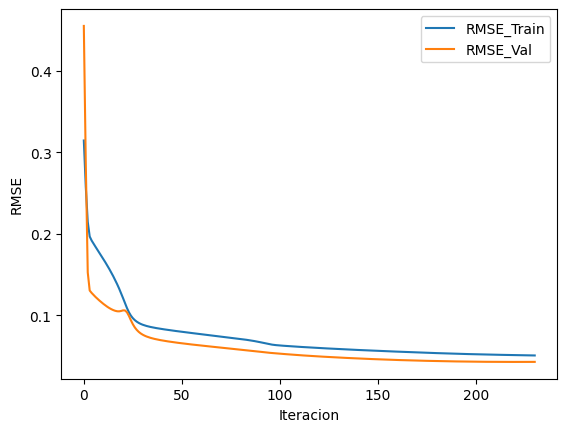

In [40]:
plt.plot(historia.history['loss'],label='RMSE_Train')
plt.plot(historia.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.legend();

**Desempeño del Modelo**

In [41]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

In [42]:
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.051
  RMSE val:	 0.041
  RMSE test:	 0.048


**Forecasting**

In [43]:
#Función predic
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [44]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

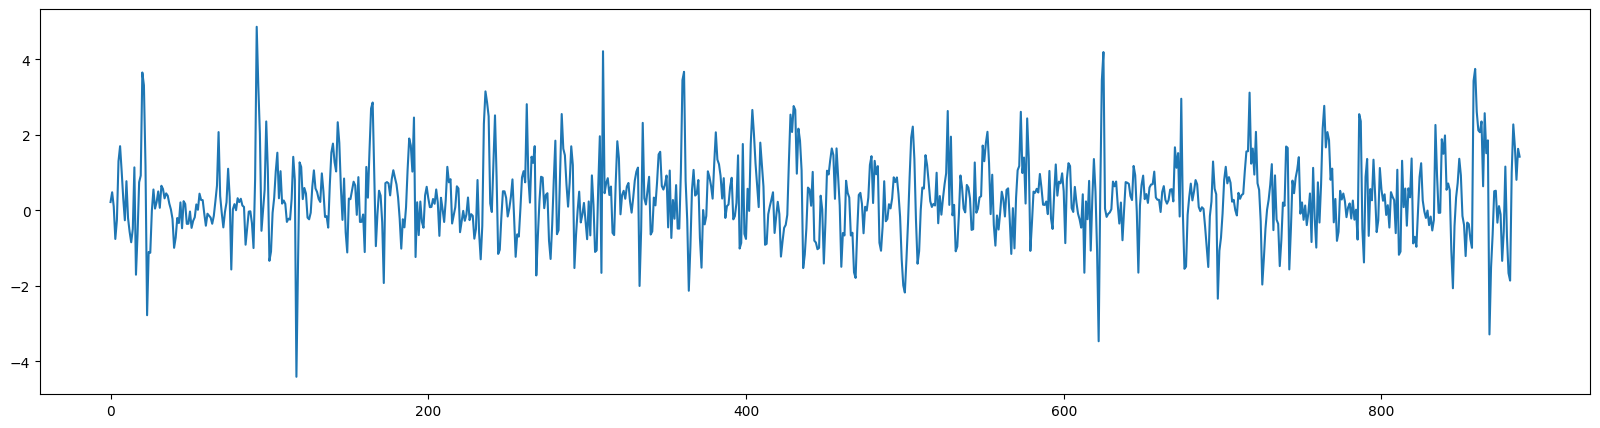

In [45]:
# Número de predicciones
N = len(y_ts_pred)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(errores);

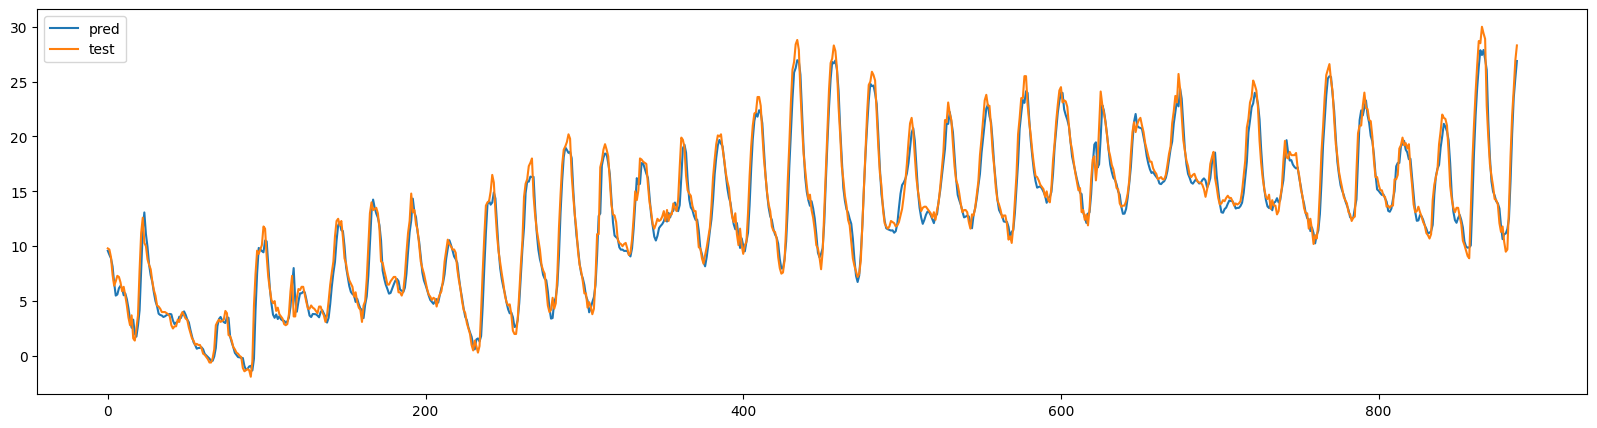

In [46]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();

In [49]:
y_ts_dim2 = y_ts.reshape(-1)
y_ts_pred_dim2 = y_ts_pred.reshape(-1)

In [50]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(y_ts_dim2, y_ts_pred_dim2)
mse = mean_squared_error(y_ts_dim2, y_ts_pred_dim2)
rmse = np.sqrt(mse)

# Imprimir las métricas de rendimiento
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.7920171005449986
MSE: 1.152880711959537
RMSE: 1.0737228282753128


**Graficar el predict sobre toda la serie, no solo el test**

In [51]:
#Prediccion sobre el conjunto de test
y_ts_pred = predecir(x_ts_s, modelo, scaler)
print(len(y_ts_pred))

888


In [52]:
#Prediccion sobre el conjunto de train
y_tr_pred = predecir(x_tr_s, modelo, scaler)
print(len(y_tr_pred))

7436


In [53]:
#Prediccion sobre le conjunto de value
y_vl_pred = predecir(x_vl_s, modelo, scaler)
print(len(y_vl_pred))

886


In [54]:
y_pred_completo = np.concatenate((y_tr_pred, y_vl_pred, y_ts_pred))
y_completo = np.concatenate((y_tr, y_vl, y_ts))

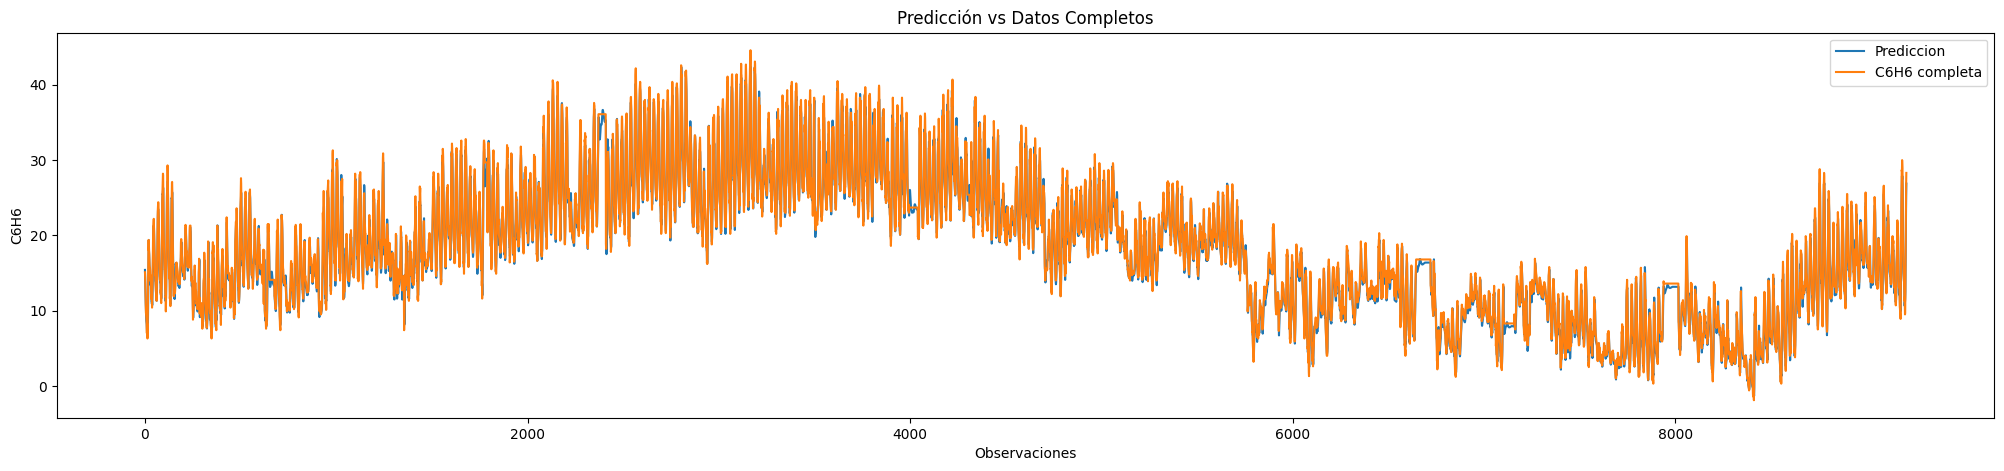

In [55]:
fig, ax = plt.subplots(figsize=(25,5))
ax.plot(y_pred_completo,label="Prediccion")
ax.plot(y_completo.flatten(),label="C6H6 completa")
ax.set_title("Predicción vs Datos Completos")
ax.set_xlabel("Observaciones")
ax.set_ylabel("C6H6")
plt.legend()
# Mostrar el gráfico
plt.show()

**Calculo de la función RMSE**

In [ ]:
#rmse sobre todo los valores predecidos
diferencia=np.square(y_completo-y_pred_completo)
proms=np.mean(diferencia)
rmse=np.sqrt(proms)
print(rmse)

12.03340725648612


In [ ]:
#rmse sobre los valores de test
diferencia2=np.square(y_ts_s-y_ts_pred)
proms2=np.mean(diferencia2)
rmse2=np.sqrt(proms2)
print(rmse2)

15.12044536258284


**Predecir con ventana = 1 (output_length=1)**

In [84]:
y_pred_completo = np.concatenate((y_tr_pred, y_vl_pred, y_ts_pred))
y_completo = np.concatenate((y_tr, y_vl, y_ts))

In [85]:
#Predecir las próximas 24 horas
def predecir_futuro(x_ultimo, model, scaler, output_length=24):
    predicciones = []

    for _ in range(output_length):
        if len(x_ultimo.shape) == 2:
            x_ultimo = x_ultimo.reshape(1, x_ultimo.shape[0], x_ultimo.shape[1])

        # Predecir la próxima salida
        y_pred_s = model.predict(x_ultimo, verbose=0)

        # Llevar la predicción a la escala original
        y_pred = scaler.inverse_transform(y_pred_s)

        # Guardar la predicción
        predicciones.append(y_pred.flatten()[0])

        # Actualizar x_ultimo para la siguiente predicción
        # Asumiendo un modelo que se puede usar de esta manera
        x_ultimo = np.append(x_ultimo[:, 1:, :], y_pred_s.reshape(1, 1, -1), axis=1)

    return np.array(predicciones)

# Predecir las próximas 24 horas
y_futuro = predecir_futuro(x_ultimo, modelo, scaler)

print("Predicción de las próximas 24 horas:", y_futuro)

Predicción de las próximas 24 horas: [26.87901   26.46699   25.44845   23.925339  22.01495   19.87157
 17.717676  15.799459  14.31328   13.348841  12.864244  12.702548
 12.629461  12.404818  11.883646  11.139819  10.571655  10.792308
 12.204907  14.5697775 17.165451  19.445845  21.08867   21.9714   ]


In [86]:
print(df_T.tail(10))

Datetime
2005-04-04 05:00:00    10.4
2005-04-04 06:00:00     9.5
2005-04-04 07:00:00     9.7
2005-04-04 08:00:00    13.5
2005-04-04 09:00:00    18.2
2005-04-04 10:00:00    21.9
2005-04-04 11:00:00    24.3
2005-04-04 12:00:00    26.9
2005-04-04 13:00:00    28.3
2005-04-04 14:00:00    28.5
Name: T, dtype: float64


In [87]:
# Filtrar las últimas 100 observaciones de la columna 'C6H6' con los indices
ultimos_100_datos = df_T.tail(100)
print(ultimos_100_datos)

Datetime
2005-03-31 11:00:00    21.0
2005-03-31 12:00:00    22.8
2005-03-31 13:00:00    24.0
2005-03-31 14:00:00    22.6
2005-03-31 15:00:00    22.5
                       ... 
2005-04-04 10:00:00    21.9
2005-04-04 11:00:00    24.3
2005-04-04 12:00:00    26.9
2005-04-04 13:00:00    28.3
2005-04-04 14:00:00    28.5
Name: T, Length: 100, dtype: float64


In [88]:
# Crear los nuevos índices a patir del último para las futuras 24 horas
ultimo_indice = pd.to_datetime("2005-04-04 14:00:00")
num_futuro = len(y_futuro)

indice_futuro = pd.date_range(start=ultimo_indice + pd.Timedelta(hours=1), periods=num_futuro, freq='H')

df_futuro = pd.DataFrame({
    'Fecha': indice_futuro,
    'Predicción': y_futuro
})

df_futuro = df_futuro.reset_index(drop=True)
df_futuro = df_futuro.set_index('Fecha')

print(df_futuro.head())


                     Predicción
Fecha                          
2005-04-04 15:00:00   26.879009
2005-04-04 16:00:00   26.466990
2005-04-04 17:00:00   25.448450
2005-04-04 18:00:00   23.925339
2005-04-04 19:00:00   22.014950


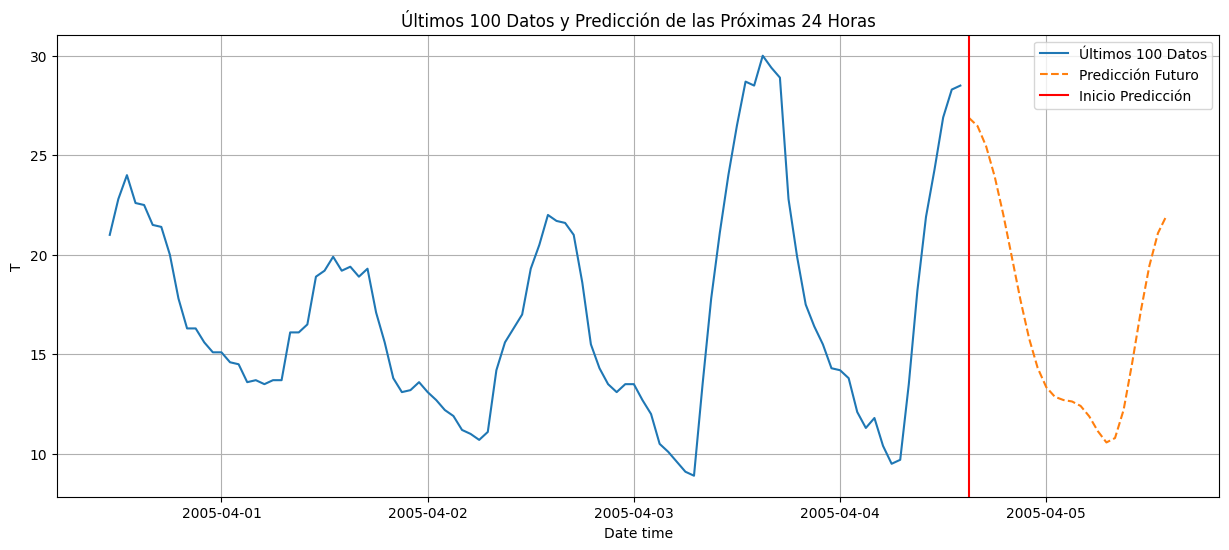

In [89]:
# Graficar los últimos 100 datos y las predicciones futuras
plt.figure(figsize=(15, 6))

# Graficar los últimos 100 datos
plt.plot(ultimos_100_datos.index, ultimos_100_datos, label='Últimos 100 Datos')

# Graficar las predicciones futuras
plt.plot(df_futuro.index, df_futuro['Predicción'], label='Predicción Futuro', linestyle='dashed')

# Agregar una línea vertical para indicar el inicio de las predicciones
plt.axvline(x=df_futuro.index[0], color='r', linestyle='-', label='Inicio Predicción')

# Configurar el gráfico
plt.xlabel('Date time')
plt.ylabel('T')
plt.title('Últimos 100 Datos y Predicción de las Próximas 24 Horas')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
y_ts_dim2 = y_ts.reshape(-1)
y_ts_pred_dim2 = y_ts_pred.reshape(-1)

In [91]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(y_ts_dim2, y_ts_pred_dim2)
mse = mean_squared_error(y_ts_dim2, y_ts_pred_dim2)
rmse = np.sqrt(mse)

# Imprimir las métricas de rendimiento
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.7920171005449986
MSE: 1.152880711959537
RMSE: 1.0737228282753128
